In [1]:
## import modules that needs to run
import numpy as np
from SignalProcessing.preprocess_signal import Prep_signal
import matplotlib.pyplot as plt
from matplotlib import gridspec
from Utils.utils import Utilfunc, import_config
from Model.Decoding import Model
from FileIO.fileio import FileIO
from mpl_toolkits.axes_grid1.axes_divider import make_axes_locatable
from mpl_toolkits.axes_grid1.colorbar import colorbar

In [2]:
## import analysis config file
config = import_config()

In [3]:
## show experiment setup in config file
config

{'setting': {'srate': 1000,
  'dwn_rate': 2,
  'filter_order': 4,
  'smoothing': 4,
  'epoch_range': [-1.0, 1.5],
  'baseline': [-1.0, -0.2],
  'reference_type': 'Average',
  'data_path': './data/BCI4/',
  'event_id': 256,
  'filter_band': [0.5, 499.9],
  'Rectify_band': [1, 249],
  'smooth4BCI4': [50, 50]},
 'feature_freqs': {'delta': [1.5, 4.0],
  'theta': [4.0, 8.0],
  'alpha': [8.0, 12.0],
  'beta': [13.0, 31.0],
  'gamma': [32.0, 49.0],
  'high-gamma1': [50.0, 99.9],
  'high-gamma2': [100.0, 149.9],
  'high-gamma3': [150.0, 199.9],
  'high-gamma4': [200.0, 249.9]},
 'Decoding': {'sliding_step': 2, 'sample_points': 10},
 'Subject': {'subject_no': 3, 'analysis_finger': 5}}

In [4]:
## input subject and finger id

# set analysis finger
finger_id = 1
# set subject number
subj_num =2

In [5]:
## generate instances    
prep = Prep_signal(config=config)
uti = Utilfunc(config)
Decoder = Model(config)
fio = FileIO(config)
# prep_signal: siganl processing instance. 
# Utilfunc: util functiion instance. 
# Model: Machine learning instance.
# FileIO: file manipulation instance.

In [6]:
## load BCIⅣ dataset with fio.loadBCI4.
data = fio.loadBCI4()[subj_num]

# data is loaded as 'dict' type. you can show contents with keys of 'data'.
# trainig_data : ECoG data that recoded with digit flection simultaneously. 
# trainig_dg : finger flection data. 
data.keys()


dict_keys(['__header__', '__version__', '__globals__', 'train_data', 'test_data', 'train_dg'])

In [7]:
## downsampling ECoG and digit flextion signals 2000Hz to 500 Hz
resampled_dg = prep.downsample_sig(data['train_dg'])
resampled_ecog = prep.downsample_sig(data['train_data'])


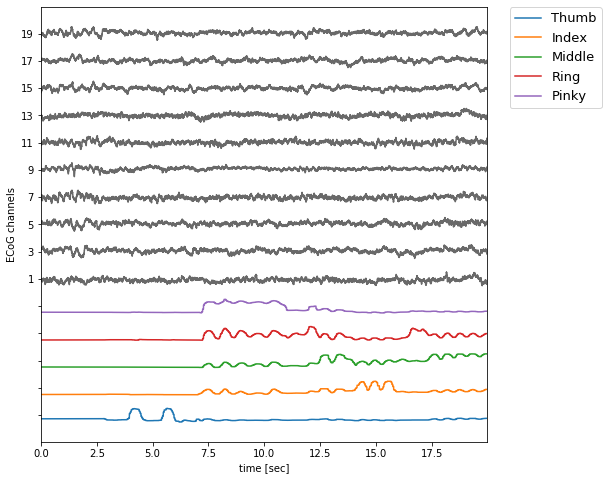

In [31]:
## plot ECoG and digit flextion signals along time series.
finger = ['Thumb','Index','Middle','Ring','Pinky']
bias = 0
chan_name =[]
time = np.arange(0,10000/prep.srate,1/prep.srate)
plt.figure(figsize=(8,8))
for fin in range(resampled_dg.shape[1]):
    temp = resampled_dg[0:10000,fin] - np.min(resampled_dg[0:10000,fin])
    plot_data = temp / np.max(temp)
    plt.plot(time, plot_data+bias, label=finger[fin])
    chan_name.append('')
    bias+=2

for ch in range(10):
    temp = resampled_ecog[0:10000,ch*2] - np.min(resampled_ecog[0:10000,ch*2])
    plot_data = temp / np.max(temp)
    plt.plot(time, plot_data+bias, 'dimgray')
    bias+=2
    chan_name.append(str(ch*2+1))

plt.yticks(np.arange(0,bias,2)+0.5, chan_name, fontsize=10)
plt.xlim([0,max(time)])
plt.xlabel('time [sec]')
plt.ylabel('ECoG channels')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=13)

In [8]:
## ECoG feature extraction by using band pass filtering
F_value = prep.Feature_Ext_filt(resampled_ecog, standardization=True, smoothing=True) 


####### Filtering for feature extraction ###### 9 band
standardization : ON
Band-pass filtering (Zero-phase): 1.5 Hz to 4.0 Hz ( delta )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 4.0 Hz to 8.0 Hz ( theta )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 8.0 Hz to 12.0 Hz ( alpha )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 13.0 Hz to 31.0 Hz ( beta )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 32.0 Hz to 49.0 Hz ( gamma )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 50.0 Hz to 99.9 Hz ( high-gamma1 )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 100.0 Hz to 149.9 Hz ( high-gamma2 )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 150.0 Hz to 199.9 Hz ( high-gamma3 )
### Processing smoothing ###
Band-pass filtering (Zero-phase): 200.0 Hz to 249.9 Hz ( high-gamma4 )
### Processing smoothing ###


In [9]:
## Digit movemnt feature extraction with rectification (de-trend + abs + smoothing)
rectified_dg = prep.Rectify(resampled_dg,
                            freqs=[0.5,5], btype='band', gaussian_pram=[100,50])

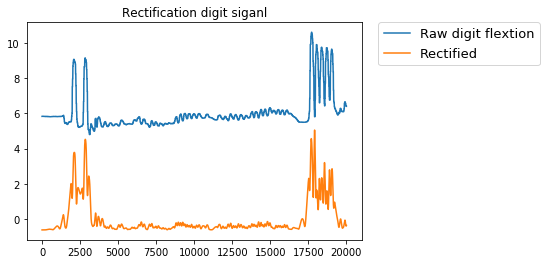

In [10]:
## plot
plt.title('Rectification digit siganl')
plt.plot(uti.Zscore(resampled_dg[0:20000,0])+6, label ='Raw digit flextion')
plt.plot(uti.Zscore(rectified_dg[0:20000,0]), label ='Rectified')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=13)

In [11]:
## set channel names 
chan = [str(i+1) for i in range(resampled_ecog.shape[1])]

In [12]:
## create trigger siganls related finger flextion onset.
# This function is only for use BCI comp 4. (Dataset no.4)
# If you want to use your custom dataset included event signal, substitute it to "trigger".
trigger =prep.CreateTriggerBCI4(data['train_dg'], threshhold=0.5, gaussian_pram=[200,50])

## set analysis finger
event = trigger[:,finger_id][:,np.newaxis].T

Text(0.5, 1.0, 'trigger signal: Index')

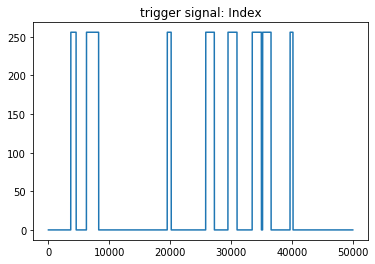

In [14]:
# plot event signals
plt.plot(event[:,0:50000].T)
plt.title('trigger signal: '+finger[finger_id])

In [15]:
## create feature Epochs
epR = uti.makeEpochs(resampled_ecog.T, event, chan).get_data()[:,0:-1,:]
ep_dg = uti.makeEpochs(rectified_dg.T, event, finger).get_data()[:,0:-1,:]

F_data = np.zeros((len(config['feature_freqs'].keys()),epR.shape[0],epR.shape[1],epR.shape[2]))
for i in range(len(config['feature_freqs'].keys())):
    F_data[i,:,:,:] = uti.makeEpochs(F_value[:,:,i].T, event, ch_info=chan, 
           reference_type='Average').get_data()[:,0:-1,:]

Ep_dg = ep_dg.transpose(0,2,1)[:,:,finger_id]
F_data = np.reshape(F_data.transpose(1,2,0,3),[F_data.shape[1],
        F_data.shape[0]*F_data.shape[2], F_data.shape[3]])

Creating RawArray with float64 data, n_channels=65, n_times=200000
    Range : 0 ... 199999 =      0.000 ...   399.998 secs
Ready.
34 events found
Event IDs: [256]
Applying average reference.
Applying a custom EEG reference.
###### Ecog signal are re-referenced by CAR #######
34 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Loading data for 34 events and 1251 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=6, n_times=200000
    Range : 0 ... 199999 =      0.000 ...   399.998 secs
Ready.
34 events found
Event IDs: [256]
Applying average reference.
Applying a custom EEG reference.
###### Ecog signal are re-referenced by CAR #######
34 matching events found
Applying baseline correction (mode: mean)
Not setting metadata
Loading data for 34 events and 1251 original time points ...
0 bad epochs dropped
Creating RawArray with float64 data, n_channels=65, n_times=200000
    Range : 0 ... 199999 =      0.000 ..

In [16]:
##### Set training and test dataset for decoding analysis.
# Four-fifths of data are used for training decoding model and remaining data is test data.
data_len= int(F_data.shape[0]*4/5)

train_ecog = F_data[0:data_len,:,:]
test_ecog = F_data[data_len:-1,:,:]

train_dg = Ep_dg[0:data_len,:]
test_dg = np.ravel(Ep_dg[data_len:-1,:])

In [17]:
## Run decoding analysis
## Partial Least Squares regression decoder is used for analysis.
weight = Decoder.Fit(train_ecog.transpose(1,0,2), train_dg, key='PLS', PLS_components=1)

## prediction and reconstruction digit flextion from ECoG siganls
reconst_dg = Decoder.runReconst(test_ecog.transpose(1,0,2), weight =weight)

In [21]:
## postproceesing
reconst_dg = uti.Zscore(reconst_dg)
test_dg = uti.Zscore(test_dg)
pad_len = int(config['Decoding']['sliding_step'] *config['Decoding']['sample_points'])
cc = np.round(np.corrcoef(reconst_dg[pad_len:-1],test_dg[pad_len:-1])[0,1],3)

R^2 score:  0.668


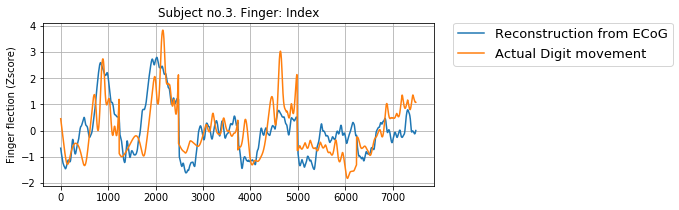

In [29]:
## plot reconstructed digit flextion with actual flextion.
plt.figure(figsize=(7,3))
plt.plot(reconst_dg[pad_len:-1], label='Reconstruction from ECoG',linewidth =1.5)
plt.plot(test_dg[pad_len:-1], label = 'Actual Digit movement',linewidth =1.5)
plt.title('Subject no.'+str(subj_num+1)+'. Finger: '+finger[finger_id])
plt.ylabel('Finger flection (Zscore)')
plt.grid()
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, fontsize=13)
print('R^2 score: ',cc)

In [32]:
## Calcurate decoding contribution ratio every electrode in ECoG array.
freqs= [config['feature_freqs'][list(config['feature_freqs'].keys())[i]] for i in range(len(config['feature_freqs'].keys()))]
spacial_weight = np.reshape(weight[0:-1],[len(chan),len(config['feature_freqs'].keys())])
freqs_domein= np.mean(spacial_weight,axis=0)
spatial_domein = np.mean(spacial_weight,axis=1)

freqs_score = (freqs_domein/np.sum(freqs_domein))*100
spacial_score = (spatial_domein/np.sum(spatial_domein))*100
reshape_score = np.reshape(spacial_score,[int(len(spacial_score)/8),8])

Text(0.5, 0, 'horizontal coordinate of ECoG array')

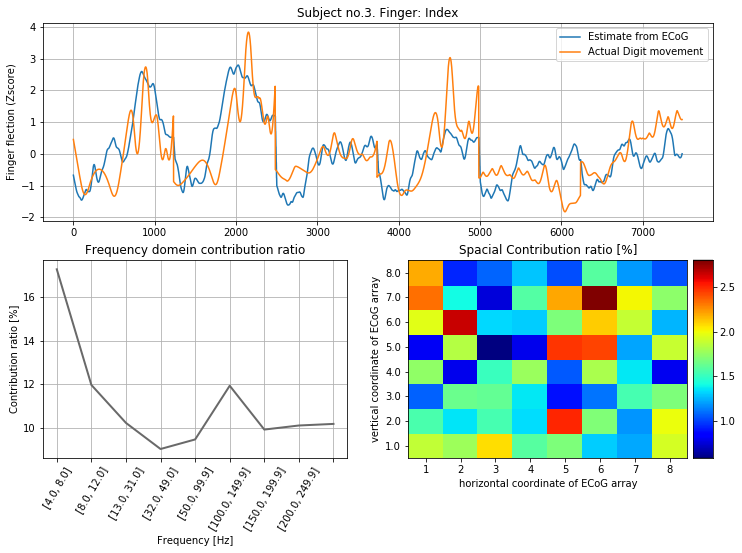

In [35]:
# plot all results
fig = plt.figure(figsize = (12,8))
gs = gridspec.GridSpec(2,2, width_ratios=[1,1]) 

ax0 = plt.subplot(gs[0,0:2]) 
ax0.plot(reconst_dg[pad_len:-1], label='Estimate from ECoG',linewidth =1.5)
ax0.plot(test_dg[pad_len:-1], label = 'Actual Digit movement',linewidth =1.5)
ax0.set_title('Subject no.'+str(subj_num+1)+'. Finger: '+finger[finger_id])
ax0.set_ylabel('Finger flection (Zscore)')
ax0.grid()
ax0.legend()

ax1 = plt.subplot(gs[1,0]) 
ax1.plot(np.arange(len(freqs)),freqs_score, color = 'dimgray', linewidth =2.0)
ax1.grid()
ax1.set_title('Frequency domein contribution ratio')
ax1.set_ylabel('Contribution ratio [%]')
ax1.set_xlabel('Frequency [Hz]')
ax1.set_xticklabels(freqs,rotation=60, fontsize=10)

ax2 = plt.subplot(gs[1,1]) 
im=ax2.pcolormesh(reshape_score,cmap='jet')
ax2_divider = make_axes_locatable(ax2)
cax2 = ax2_divider.append_axes("right", size="7%", pad="2%")
cb2 = colorbar(im, cax=cax2)    

ax2.set_yticks(np.arange(len(spacial_score)/8)+0.5)
ax2.set_yticklabels(np.arange(len(spacial_score)/8)+1)
ax2.set_xticks(np.arange(8)+0.5)
ax2.set_xticklabels(np.arange(8)+1)
ax2.set_title('Spacial Contribution ratio [%]')
ax2.set_ylabel('vertical coordinate of ECoG array')
ax2.set_xlabel('horizontal coordinate of ECoG array')
